In [146]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
Scaler = MinMaxScaler()
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [147]:
# Load testing dataset(Daily data)
def read_daily_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

In [148]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [149]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [150]:
# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [151]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [152]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [153]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [154]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [155]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [156]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[df['Date']<test_time[0]]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y_scaled,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [157]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short:')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

Load training data (containing nutrient observations)
Lake name in short:Ekoln
Winter data or not? (Y/N)N


In [183]:
# Create the daily df with Nan in nutrients columns'
print(all_df.info())
n_Nut = int(input('Number of nutrients: (including Chl)'))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)
Nut = all_df[Nut_f]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             209 non-null    datetime64[ns]
 1   thermD           209 non-null    float64       
 2   MLD              209 non-null    float64       
 3   SW               209 non-null    float64       
 4   AirT             209 non-null    float64       
 5   Prec(mm)         209 non-null    float64       
 6   relhum           209 non-null    float64       
 7   Wdir             205 non-null    float64       
 8   Wspeed(m/s)      209 non-null    float64       
 9   CC               209 non-null    float64       
 10  Inflow           209 non-null    float64       
 11  W                209 non-null    float64       
 12  delT             209 non-null    float64       
 13  Ice_d            209 non-null    int64         
 14  day_from_iceoff  209 non-null    float64  

In [162]:
n_feature = int(input('Number of features used for basic training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

Number of features used for basic training: 13
Feature:thermD
Feature:MLD
Feature:SW
Feature:AirT
Feature:Prec(mm)
Feature:relhum
Feature:Wspeed(m/s)
Feature:CC
Feature:Inflow
Feature:W
Feature:delT
Feature:Ice_d
Feature:day_from_iceoff
['Date', 'thermD', 'MLD', 'SW', 'AirT', 'Prec(mm)', 'relhum', 'Wspeed(m/s)', 'CC', 'Inflow', 'W', 'delT', 'Ice_d', 'day_from_iceoff']


In [163]:
# date to seperate training and test sets
YY=all_df['Date'].apply(lambda d:d.year).unique()
print(YY)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

[1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016]
test starts in year:2005
test ends in year:2017


In [164]:
# Read daily observation data
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
Daily_df = read_daily_df(test_time,features,file) 

In [165]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':200,'dropout':0.1,'time_steps':7,'n_out':1,'verbose':0}

In [166]:
# Change to the LSTM folder
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\LSTM')

Nutrient: O2
(5410, 8, 13) (5410,) (3293, 8, 13) (3293,)
number of input timesteps: 8
number of features: 13
number of samples: 110
Test RMSE: 0.88
Test R2: 0.62
Training dataset RMSE 1.06 (+/- 0.16)
Training dataset R2 0.50 (+/- 0.23)
Model takes 4 min to run


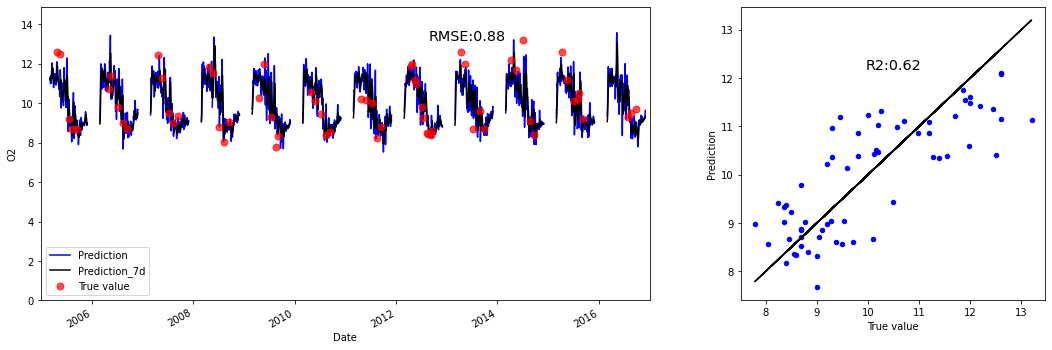

In [167]:
# predict nutreint 1
nutrient = input('Nutrient: ')
# If add the features from process-based model, add features 'MLD','W','thermD'
features.pop(0) # Remove 'Date'
features.append(nutrient)
Nut_memory = Daily_df.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                            how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [168]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,O2
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,8.752869
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,8.752869
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,8.752869
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,8.752869
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,8.752869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,9.273822
8706,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,9.260706
8707,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,9.409769
8708,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,9.418007


Nutrient: NOX
['thermD', 'MLD', 'SW', 'AirT', 'Prec(mm)', 'relhum', 'Wspeed(m/s)', 'CC', 'Inflow', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'O2']
Delete features? (Y/N)N
Add features? (Y/N)N
(5414, 8, 14) (5414,) (3293, 8, 14) (3293,)
number of input timesteps: 8
number of features: 14
number of samples: 114
Test RMSE: 248.77
Test R2: 0.47
Training dataset RMSE 256.09 (+/- 18.44)
Training dataset R2 0.40 (+/- 0.14)
Model takes 5 min to run


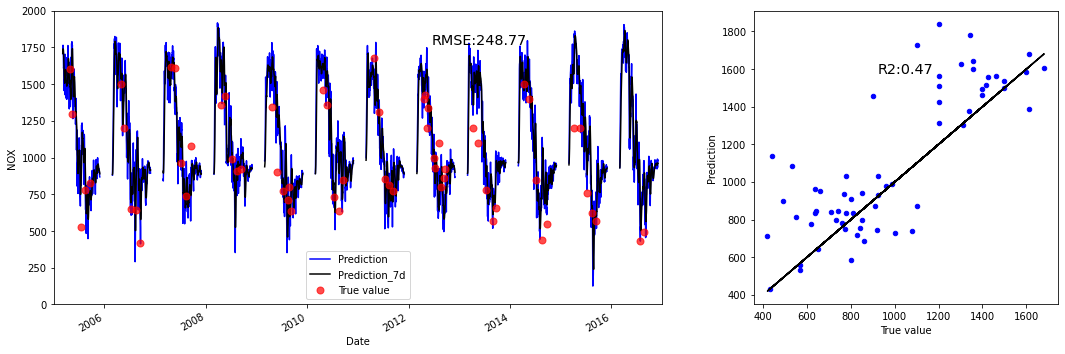

In [169]:
# predict nutreint 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates()
                              ,how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [170]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,O2,NOX
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,8.752869,1159.034302
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,8.752869,1159.034302
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,8.752869,1159.034302
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,8.752869,1159.034302
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,8.752869,1159.034302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8709,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,9.273822,966.303955
8710,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,9.260706,990.087463
8711,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,9.409769,976.070496
8712,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,9.418007,984.263916


Nutrient: NH4-N
['thermD', 'MLD', 'SW', 'AirT', 'Prec(mm)', 'relhum', 'Wspeed(m/s)', 'CC', 'Inflow', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'O2', 'NOX']
Delete features? (Y/N)N
Add features? (Y/N)N
(5422, 8, 15) (5422,) (3293, 8, 15) (3293,)
number of input timesteps: 8
number of features: 15
number of samples: 122
Test RMSE: 10.36
Test R2: 0.06
Training dataset RMSE 14.55 (+/- 1.96)
Training dataset R2 -0.70 (+/- 1.17)
Model takes 6 min to run


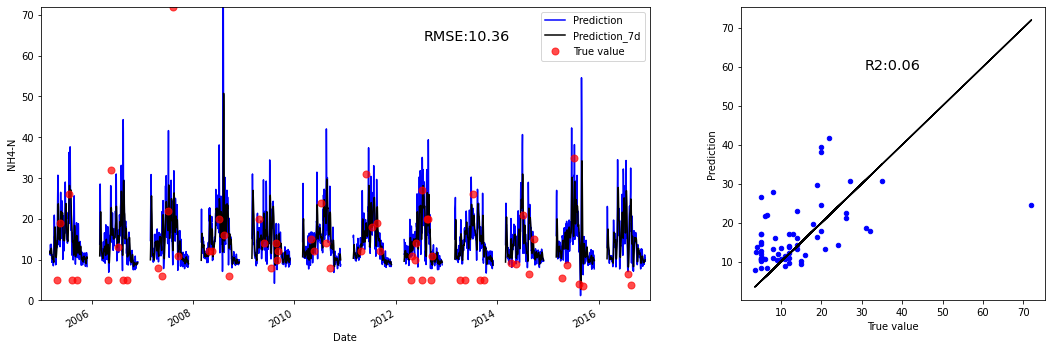

In [171]:
# predict nutreint 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [172]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,O2,NOX,NH4-N
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,8.752869,1159.034302,36.833191
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,8.752869,1159.034302,36.833191
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,8.752869,1159.034302,36.833191
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,8.752869,1159.034302,36.833191
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,8.752869,1159.034302,36.833191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8717,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,9.273822,966.303955,9.582341
8718,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,9.260706,990.087463,11.162330
8719,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,9.409769,976.070496,9.968813
8720,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,9.418007,984.263916,10.308342


Nutrient: PO4-P
['thermD', 'MLD', 'SW', 'AirT', 'Prec(mm)', 'relhum', 'Wspeed(m/s)', 'CC', 'Inflow', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'O2', 'NOX', 'NH4-N']
Delete features? (Y/N)N
Add features? (Y/N)N
(5438, 8, 16) (5438,) (3293, 8, 16) (3293,)
number of input timesteps: 8
number of features: 16
number of samples: 138
Test RMSE: 7.35
Test R2: 0.71
Training dataset RMSE 10.61 (+/- 4.15)
Training dataset R2 0.05 (+/- 0.94)
Model takes 6 min to run


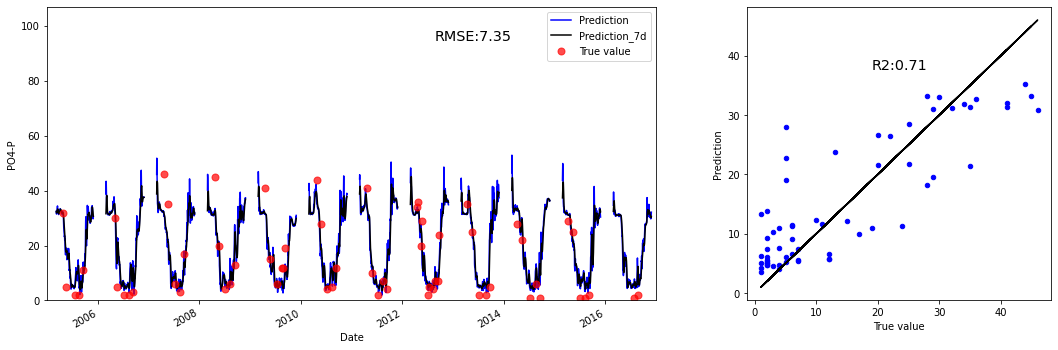

In [173]:
# predict nutreint 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [174]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,O2,NOX,NH4-N,PO4-P
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,8.752869,1159.034302,36.833191,14.603727
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,8.752869,1159.034302,36.833191,14.603727
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,8.752869,1159.034302,36.833191,14.603727
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,8.752869,1159.034302,36.833191,14.603727
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,8.752869,1159.034302,36.833191,14.603727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8733,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,9.273822,966.303955,9.582341,30.199030
8734,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,9.260706,990.087463,11.162330,29.770081
8735,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,9.409769,976.070496,9.968813,31.031603
8736,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,9.418007,984.263916,10.308342,31.194315


Nutrient: Tot-P
['thermD', 'MLD', 'SW', 'AirT', 'Prec(mm)', 'relhum', 'Wspeed(m/s)', 'CC', 'Inflow', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'O2', 'NOX', 'NH4-N', 'PO4-P']
Delete features? (Y/N)N
Add features? (Y/N)N
(5470, 8, 17) (5470,) (3293, 8, 17) (3293,)
number of input timesteps: 8
number of features: 17
number of samples: 170
Test RMSE: 15.17
Test R2: 0.10
Training dataset RMSE 14.50 (+/- 5.60)
Training dataset R2 0.08 (+/- 0.36)
Model takes 8 min to run


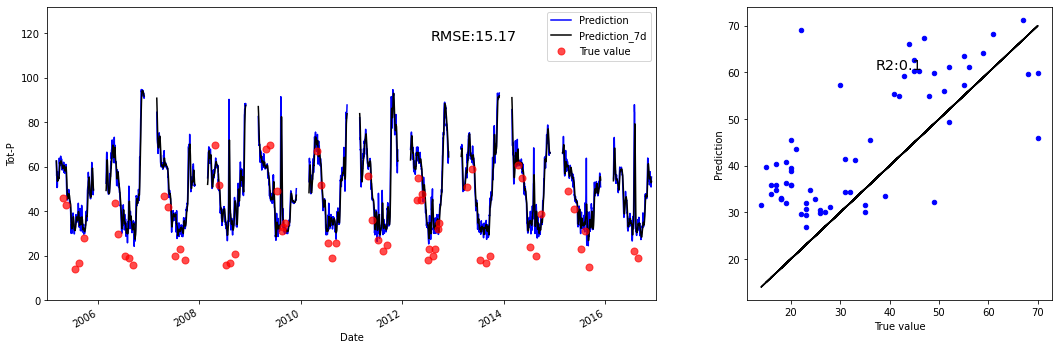

In [175]:
# predict nutreint 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [176]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,O2,NOX,NH4-N,PO4-P,Tot-P
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,8.752869,1159.034302,36.833191,14.603727,50.189014
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,8.752869,1159.034302,36.833191,14.603727,50.189014
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,8.752869,1159.034302,36.833191,14.603727,50.189014
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,8.752869,1159.034302,36.833191,14.603727,50.189014
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,8.752869,1159.034302,36.833191,14.603727,50.189014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8765,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,9.273822,966.303955,9.582341,30.199030,52.069592
8766,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,9.260706,990.087463,11.162330,29.770081,50.968594
8767,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,9.409769,976.070496,9.968813,31.031603,53.639835
8768,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,9.418007,984.263916,10.308342,31.194315,54.553333


Nutrient: Si
['thermD', 'MLD', 'SW', 'AirT', 'Prec(mm)', 'relhum', 'Wspeed(m/s)', 'CC', 'Inflow', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'O2', 'NOX', 'NH4-N', 'PO4-P', 'Tot-P']
Delete features? (Y/N)N
Add features? (Y/N)N
(5534, 8, 18) (5534,) (3293, 8, 18) (3293,)
number of input timesteps: 8
number of features: 18
number of samples: 234
Test RMSE: 1.31
Test R2: 0.31
Training dataset RMSE 0.69 (+/- 0.05)
Training dataset R2 0.48 (+/- 0.17)
Model takes 12 min to run


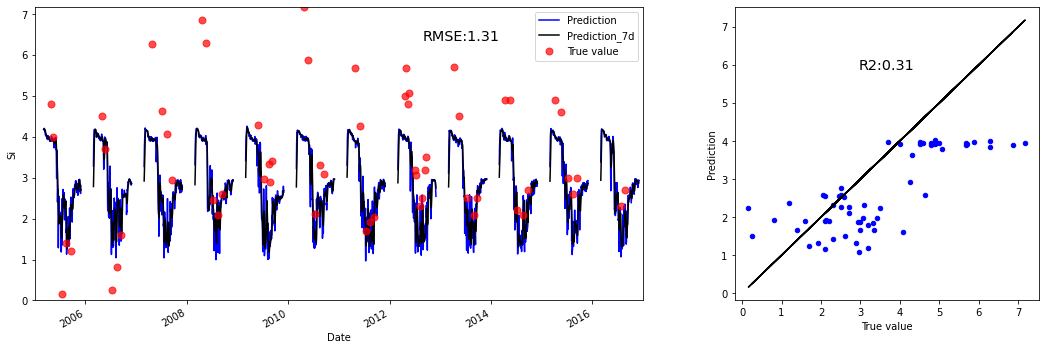

In [177]:
# predict nutreint 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [178]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,O2,NOX,NH4-N,PO4-P,Tot-P,Si
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,9.273822,966.303955,9.582341,30.199030,52.069592,2.888440
8830,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,9.260706,990.087463,11.162330,29.770081,50.968594,2.913347
8831,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,9.409769,976.070496,9.968813,31.031603,53.639835,2.919157
8832,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,9.418007,984.263916,10.308342,31.194315,54.553333,2.945415


Nutrient: TOTN
['AirP', 'AirT', 'RelHum', 'SWR', 'Prec', 'CC', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'NO3N', 'O2', 'PO4P', 'TOC', 'SiO2']
Delete features? (Y/N)N
Add features? (Y/N)N
(5225, 8, 20) (5225,) (818, 8, 20) (818,)
number of input timesteps: 8
number of features: 20
number of samples: 195
Test RMSE: 204.11
Test R2: 0.02
Training dataset RMSE 128.19 (+/- 14.39)
Training dataset R2 0.66 (+/- 0.07)
Model takes 6 min to run


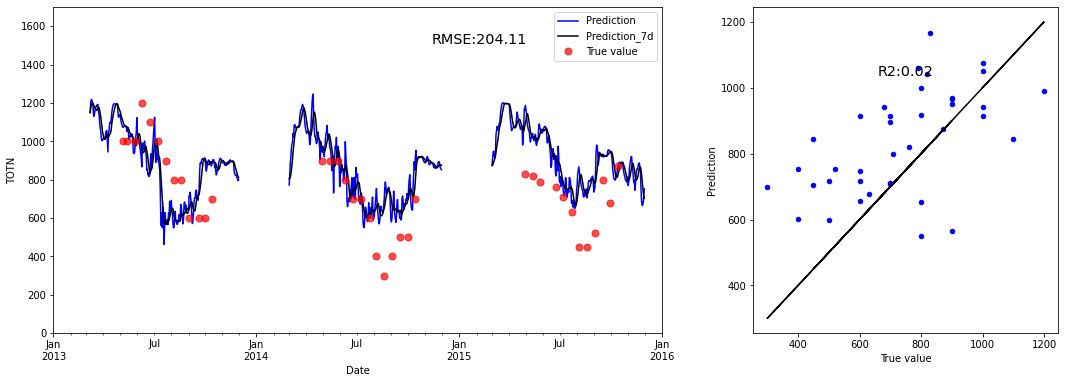

In [59]:
# predict nutreint 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [60]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,Prec,CC,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,NO3N,NH4N,O2,PO4P,TOC,SiO2,TOTN
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.830272,0.458692,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,1.530000,0.854867,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.423039,0.993754,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.000784,0.708459,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,0.338688,1.000008,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.000000,0.548573,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,21.003368,31.282879,9.494571,6.466239,8.121214,1.742163,665.334106
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.001345,0.968004,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,30.501335,34.556225,10.115715,5.661668,7.792230,2.293807,668.251038
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.003703,0.634158,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,48.009514,41.300682,9.916005,6.195094,7.691663,2.616372,681.385437
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.000335,0.928686,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,88.986794,44.988178,9.411903,5.799950,7.743204,3.051733,721.415222


In [179]:
# predict nutreint 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

KeyboardInterrupt: Interrupted by user

In [62]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,Prec,CC,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,NO3N,NH4N,O2,PO4P,TOC,SiO2,TOTN,TOTP
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.830272,0.458692,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,1.530000,0.854867,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.423039,0.993754,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.000784,0.708459,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,0.338688,1.000008,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.000000,0.548573,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,21.003368,31.282879,9.494571,6.466239,8.121214,1.742163,665.334106,29.505936
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.001345,0.968004,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,30.501335,34.556225,10.115715,5.661668,7.792230,2.293807,668.251038,28.986773
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.003703,0.634158,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,48.009514,41.300682,9.916005,6.195094,7.691663,2.616372,681.385437,28.893240
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.000335,0.928686,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,88.986794,44.988178,9.411903,5.799950,7.743204,3.051733,721.415222,29.062391


Nutrient: Chl
['thermD', 'MLD', 'SW', 'AirT', 'Prec(mm)', 'relhum', 'Wspeed(m/s)', 'CC', 'Inflow', 'W', 'delT', 'Ice_d', 'day_from_iceoff', 'O2', 'NOX', 'NH4-N', 'PO4-P', 'Tot-P', 'Si']
Delete features? (Y/N)N
Add features? (Y/N)N
(5662, 8, 19) (5662,) (3293, 8, 19) (3293,)
number of input timesteps: 8
number of features: 19
number of samples: 361
Test RMSE: 8.21
Test R2: 0.15
Training dataset RMSE 6.19 (+/- 0.54)
Training dataset R2 0.29 (+/- 0.17)
Model takes 18 min to run


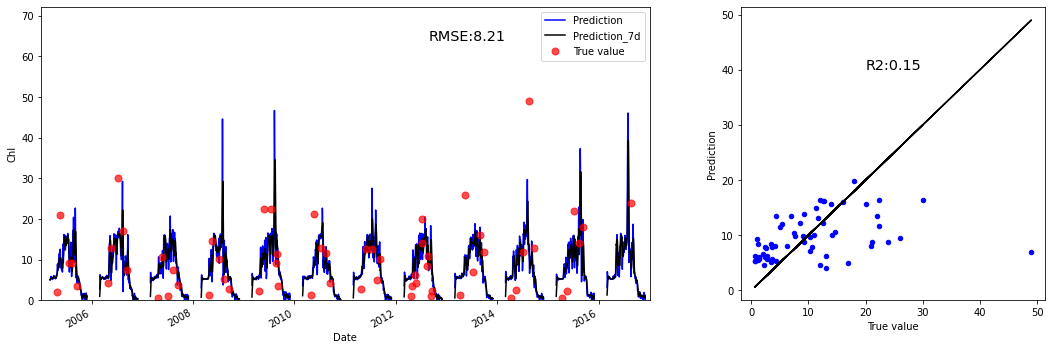

In [180]:
# predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [181]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,MLD,SW,AirT,Prec(mm),relhum,Wspeed(m/s),CC,Inflow,W,delT,Ice_d,day_from_iceoff,O2,NOX,NH4-N,PO4-P,Tot-P,Si,Chl
0,1985-06-01,-5.1288,-36.800000,330.452972,15.042857,0.0,50.915331,1.857143,13.000000,18.49700,0.006491,-0.028141,52,1.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652,5.674751
1,1985-06-02,-5.1740,-36.800000,287.437134,16.337500,0.0,57.831367,2.125000,29.333333,17.61220,0.002736,-0.026636,52,2.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652,5.674751
2,1985-06-03,-5.1099,-36.800000,316.613037,12.787500,0.0,60.203456,1.875000,17.000000,16.76990,0.003248,-0.025157,52,3.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652,5.674751
3,1985-06-04,-2.0940,-36.800000,236.220017,14.212500,0.0,67.076609,2.125000,29.333333,15.96790,0.007439,-0.023692,52,4.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652,5.674751
4,1985-06-05,-3.0402,-36.800000,161.675079,11.687500,0.0,74.664693,2.312500,75.333333,15.20430,0.003512,-0.022288,52,5.0,8.752869,1159.034302,36.833191,14.603727,50.189014,3.617652,5.674751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8957,2016-11-26,-36.8000,-3.532513,24.086670,4.541667,0.0,80.758119,3.000000,87.666667,3.37906,0.239439,11.652964,71,182.0,9.273822,966.303955,9.582341,30.199030,52.069592,2.888440,0.820913
8958,2016-11-27,-36.8000,-4.199191,17.341513,0.904167,0.8,68.990930,5.041667,100.000000,3.00745,0.309954,11.773296,71,183.0,9.260706,990.087463,11.162330,29.770081,50.968594,2.913347,1.387004
8959,2016-11-28,-36.8000,-4.807006,20.723717,-0.616667,1.0,71.523287,3.041667,37.666667,2.97112,0.198888,11.689419,71,184.0,9.409769,976.070496,9.968813,31.031603,53.639835,2.919157,0.549142
8960,2016-11-29,-36.8000,-5.738499,13.158552,0.800000,0.0,85.063364,2.041667,96.000000,2.71484,0.542602,11.232962,71,185.0,9.418007,984.263916,10.308342,31.194315,54.553333,2.945415,0.845865


In [182]:
Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',index=False)